In [1]:
import torch  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
print(device)

cuda


In [8]:
import pandas as pd  
import numpy as np  
import torch.nn as nn  
from sklearn.preprocessing import MinMaxScaler  
from sklearn.metrics import r2_score 
  
# Load and preprocess data  
df = pd.read_csv('resampled_cpu_usage_per_machine.csv')  
df['start_time'] = pd.to_datetime(df['start_time'])  
df.set_index('start_time', inplace=True)  
  
# Select one machine  
df = df[df['machine_id'] == df['machine_id'].values[1]]  
df = df[['maximum_cpu_usage']]  
  
# Scale data to (0, 1) for LSTM  
scaler = MinMaxScaler(feature_range=(0, 1))  
df['maximum_cpu_usage'] = scaler.fit_transform(df['maximum_cpu_usage'].values.reshape(-1,1))  
  
# Convert DataFrame to numpy array  
data = df['maximum_cpu_usage'].values  

# Split data into train and test sets  
seq_length_in = 144
seq_length_out = 6
train_size = int(len(data) * 0.80)  
train_data, test_data = data[:train_size], data[train_size:] 

# Create sequences  
def create_sequences(input_data, seq_length_in, seq_length_out):  
    inout_seq = []  
    L = len(input_data)  
    for i in range(L-seq_length_in-seq_length_out):  
        train_seq = torch.FloatTensor(input_data[i:i+seq_length_in])
        train_label = torch.FloatTensor(input_data[i+seq_length_in:i+seq_length_in+seq_length_out]) 
        inout_seq.append((train_seq ,train_label))  
    return inout_seq  
  
train_inout_seq = create_sequences(train_data, seq_length_in, seq_length_out) 

# Create DataLoader for mini-batches, take 64 each time
batch_size = 128
train_data_loader = torch.utils.data.DataLoader(train_inout_seq, batch_size=batch_size, shuffle=True)  
  
# Define LSTM model  
class LSTM(nn.Module):  
    def __init__(self, input_size, hidden_size, num_layers, output_size):  
        super(LSTM, self).__init__()  
        self.hidden_size = hidden_size  
        self.num_layers = num_layers  
  
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)  
        self.fc = nn.Linear(hidden_size, output_size)  
  
    def forward(self, x):  
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  
  
        out, _ = self.lstm(x, (h_0, c_0))  
        out = self.fc(out[:, -1, :])  
  
        return out  
  
# Set up LSTM model parameters
num_epochs = 2000
learning_rate = 0.01  
input_size = 1  
hidden_size = 4
num_layers = 1
output_size = seq_length_out
  
lstm = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
  
# Set loss function and optimizer  
criterion = torch.nn.MSELoss()    # mean-squared error for regression  
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)   
  
# Train model  
lstm.train()
for epoch in range(num_epochs):  
    for i, (seq, labels) in enumerate(train_data_loader): 
        # FloatTensor: This is a multi-dimensional matrix containing elements of a single data type, in this case, float. It's a specific type of tensor provided by PyTorch.
        # Tensor: This is a general term used for n-dimensional arrays in PyTorch. When you create a Tensor in PyTorch without specifying a type, it defaults to FloatTensor. So, torch.Tensor is essentially equivalent to torch.FloatTensor.
        # tensor: This is a function in PyTorch used to create a Tensor. It's similar to FloatTensor, but it infers the data type from the data. If you pass in floats, it will create a FloatTensor. If you pass in integers, it will create an IntTensor, etc.
        # The -1 in .view(-1, seq_length_out) is a placeholder that PyTorch will fill in with the appropriate number to maintain the same total number of elements in the tensor. For example, if you have a tensor of shape (4, 3) and you do .view(-1, 2), the resulting tensor will have shape (6, 2), as PyTorch fills in the -1 with a 6 to maintain the same total number of elements (12 in this case).
        seq = torch.FloatTensor(seq).view(-1, seq_length_in, input_size).to(device)
        labels = torch.FloatTensor(labels).view(-1, seq_length_out).to(device)
          
        optimizer.zero_grad()  
        y_pred = lstm(seq)  
          
        single_loss = criterion(y_pred, labels)  
        single_loss.backward()  
        optimizer.step()  
  
    if (epoch+1)%200 == 0:  
        train_rmse = np.sqrt(single_loss.item())
        train_mse = np.mean(single_loss.item())
        print('epoch: ', epoch+1, 'train RMSE: ', train_rmse, 'train MSE: ', train_mse, 'loss: ', single_loss.item())     
  
# Test model
lstm.eval()
test_inout_seq = create_sequences(test_data, seq_length_in, seq_length_out)
predictions = []
test_rmse = 0
test_mse = 0
ttl = 0
predictions = []  
actuals = [] 
with torch.no_grad():  
    for seq, labels in test_inout_seq:  
        seq = torch.FloatTensor(seq).view(-1, seq_length_in, input_size).to(device)  
        labels = torch.FloatTensor(labels).view(-1, seq_length_out).to(device)  
        y_test_pred = lstm(seq)  
          
        # Ensure labels and y_test_pred have the same size  
        if y_test_pred.shape != labels.shape:  
            print("Shape mismatch: y_test_pred has shape {} but labels have shape {}".format(y_test_pred.shape, labels.shape))  
            continue  

        predictions.append(y_test_pred.cpu().detach().numpy())  
        actuals.append(labels.cpu().detach().numpy())  
  
        test_loss = criterion(y_test_pred, labels) 
        test_rmse += np.sqrt(test_loss.item())
        test_mse += np.mean(test_loss.item())
        ttl += 1
        
# Flatten the lists of predictions and actuals into 1D arrays  
predictions = np.concatenate(predictions).ravel()  
actuals = np.concatenate(actuals).ravel()  
  
r2 = r2_score(actuals, predictions)  
        
print('test RMSE: ', test_rmse/ttl, 'test MSE: ', test_mse/ttl, 'r2-score: ', r2)   
       


epoch:  200 train RMSE:  0.12207007980324501 train MSE:  0.014901104383170605 loss:  0.014901104383170605
epoch:  400 train RMSE:  0.12391144284025687 train MSE:  0.015354045666754246 loss:  0.015354045666754246
epoch:  600 train RMSE:  0.12439007894724131 train MSE:  0.015472891740500927 loss:  0.015472891740500927
epoch:  800 train RMSE:  0.11740333628421348 train MSE:  0.01378354337066412 loss:  0.01378354337066412
epoch:  1000 train RMSE:  0.11776285392818181 train MSE:  0.013868089765310287 loss:  0.013868089765310287
epoch:  1200 train RMSE:  0.12597677689171816 train MSE:  0.015870148316025734 loss:  0.015870148316025734
epoch:  1400 train RMSE:  0.12536468802087034 train MSE:  0.015716305002570152 loss:  0.015716305002570152
epoch:  1600 train RMSE:  0.11422047453281604 train MSE:  0.013046316802501678 loss:  0.013046316802501678
epoch:  1800 train RMSE:  0.12542337007868282 train MSE:  0.015731021761894226 loss:  0.015731021761894226
epoch:  2000 train RMSE:  0.115295672681437

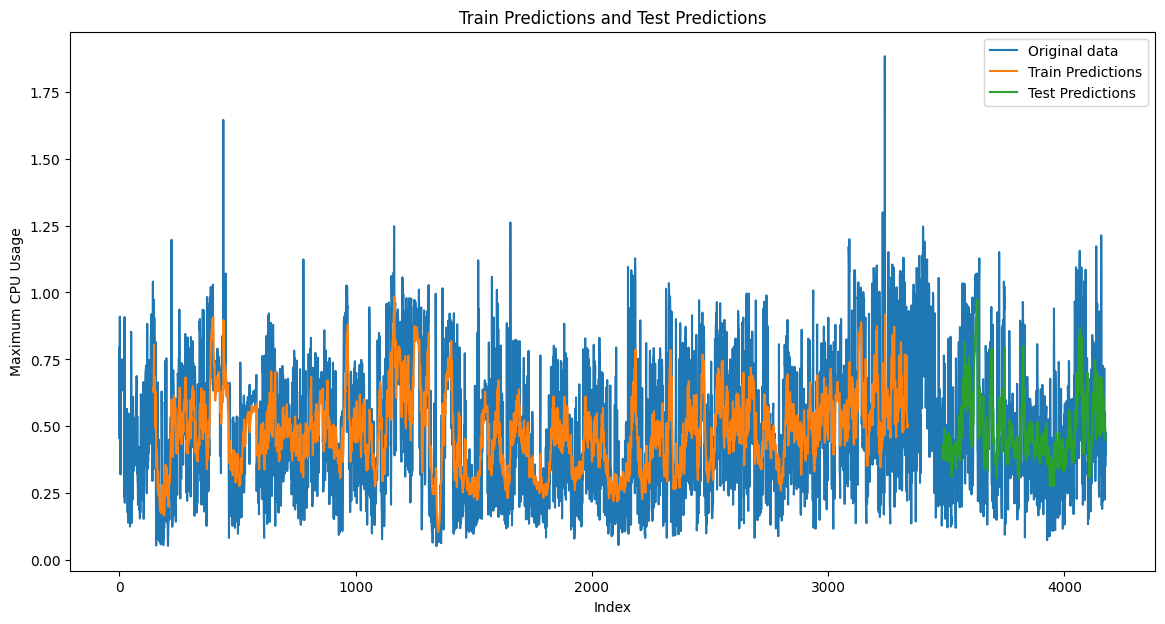

In [9]:
import matplotlib.pyplot as plt  

# Create empty arrays of NaNs  
train_predictions = np.empty_like(data)  
train_predictions[:] = np.nan  
test_predictions = np.empty_like(data)  
test_predictions[:] = np.nan  
  
# Generate predictions  
lstm.eval()  
with torch.no_grad():  
    for i, (seq, labels) in enumerate(train_inout_seq):  
        seq = torch.FloatTensor(seq).view(-1, seq_length_in, input_size).to(device)  
        train_pred = lstm(seq)  
        train_predictions[i+seq_length_in : i+seq_length_in+seq_length_out] = train_pred.cpu().numpy().flatten()  
  
    for i, (seq, labels) in enumerate(test_inout_seq):  
        seq = torch.FloatTensor(seq).view(-1, seq_length_in, input_size).to(device)  
        test_pred = lstm(seq)  
        test_predictions[i+train_size+seq_length_in : i+train_size+seq_length_in+seq_length_out] = test_pred.cpu().numpy().flatten()  

train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1))  
test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))  
data = scaler.inverse_transform(data.reshape(-1, 1))  
  
# Plotting  
plt.figure(figsize=(14, 7))  
  
# Original data  
plt.plot(range(len(data)), data, label='Original data')  
  
# Train predictions  
plt.plot(range(len(data)), train_predictions, label='Train Predictions')  
  
# Test predictions  
plt.plot(range(len(data)), test_predictions, label='Test Predictions')  
  
plt.title('Train Predictions and Test Predictions')  
plt.xlabel('Index')  
plt.ylabel('Maximum CPU Usage')  
plt.legend()  
plt.show()  


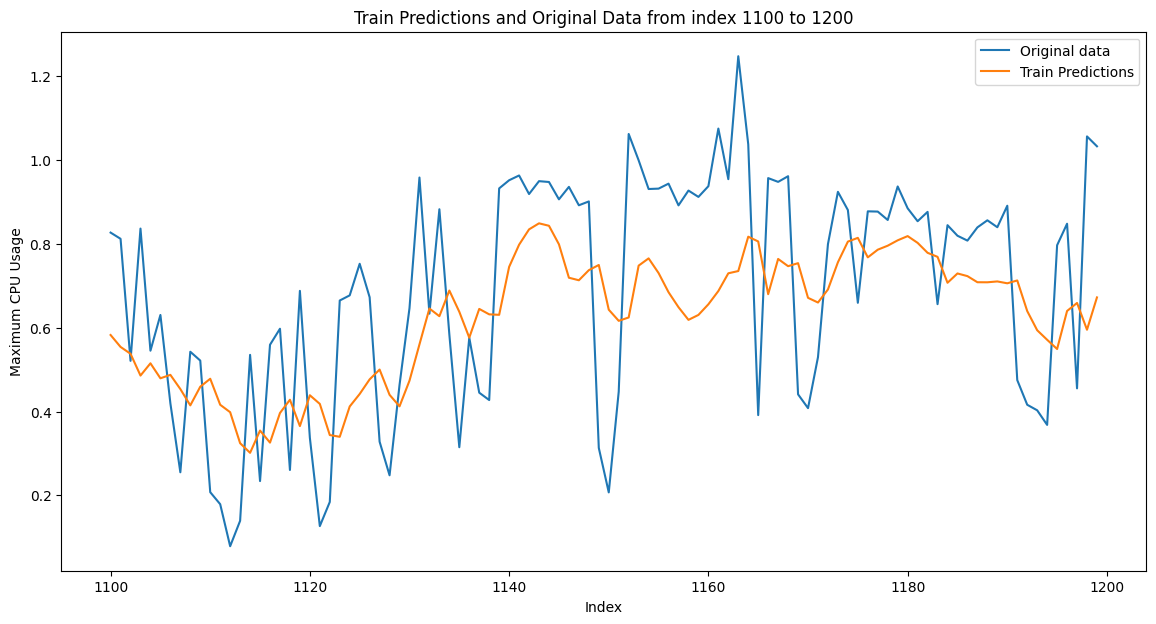

In [4]:
# Define the range of interest  
start_index = 1100  
end_index = 1200  
  
# Plotting  
plt.figure(figsize=(14, 7))  
  
# Original data  
plt.plot(range(start_index, end_index), data[start_index:end_index], label='Original data')  
  
# Train predictions  
plt.plot(range(start_index, end_index), train_predictions[start_index:end_index], label='Train Predictions')  
  
plt.title('Train Predictions and Original Data from index 1100 to 1200')  
plt.xlabel('Index')  
plt.ylabel('Maximum CPU Usage')  
plt.legend()  
plt.show()  


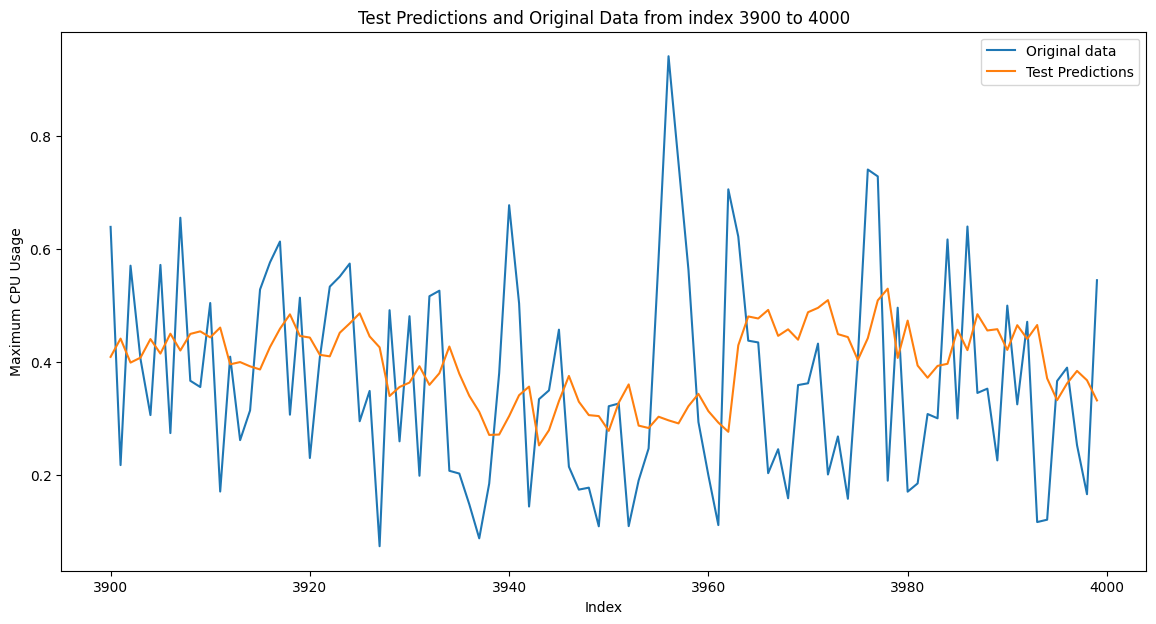

In [5]:
# Define the range of interest  
start_index = 3900  
end_index = 4000  
  
# Plotting  
plt.figure(figsize=(14, 7))  
  
# Original data  
plt.plot(range(start_index, end_index), data[start_index:end_index], label='Original data')  
  
# Test predictions  
plt.plot(range(start_index, end_index), test_predictions[start_index:end_index], label='Test Predictions')  
  
plt.title('Test Predictions and Original Data from index 3900 to 4000')  
plt.xlabel('Index')  
plt.ylabel('Maximum CPU Usage')  
plt.legend()  
plt.show()  
